In [57]:
#modeling sky subtraction model vs data points for 5/19/17 night
from __future__ import division

import os

import numpy as np

from glob import glob

import reduce_dblspec

from astropy.io import fits
from astropy import units as u
from astropy.table import Table

#from astropy import modeling
from astropy.modeling import models, fitting

from astropy import constants as cnst

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt

#plt.rcParams['image.interpolation'] = 'none'
plt.rcParams['figure.figsize'] = (16, 10)

In [3]:
flatid = 'DomeFlat'
atlasfiles= fits.open('henear.fits')
targetID='68298203070473-ScoobyDoo'
all_side_files_target='DoubleSpec/20170519/red*.fits' 
model=('poly',7)
vmin=-10
vmax=40
skyaps=[(30,110),(180,400)] 

In [4]:
flats = [reduce_dblspec.DoubleSpecImage(fn).overscan_sub_and_trim() for fn in 
          reduce_dblspec.find_all_obj(flatid,'DoubleSpec/20170519/red*.fits')[:10]] #DO I WANNA KEEP AS ONLY LAST 10???
nfl = reduce_dblspec.create_normalized_flat(flats)
    
header = atlasfiles[0].header    


    
    #locating all files w/ the target & flat/overscan subt
specs = [reduce_dblspec.DoubleSpecImage(fn).overscan_sub_and_trim().flatten(nfl) 
          for fn in reduce_dblspec.find_all_obj(targetID,all_side_files_target)]
    
    
print("This is lenspecs:",len(specs))


    
    
    #stacking all that data for specific target-help increase s/n 
comb = reduce_dblspec.combine_imgs(specs)
    
    
    
'''  
    
    #plotting 2D to get skyaps right around the target
plt.figure(figsize=(20,10)) #setting up fig size
value = model[1]
if model == 'linear':
        subimg, models = comb.subtract_sky(skyaps, skymodel=modeling.models.Linear1D(1,0)) #(1,0)
elif model == ('poly',value):
        subimg, models = comb.subtract_sky(skyaps, skymodel=modeling.models.Polynomial1D(value)) #Linear1D(1/10,10)) #(1,0)
elif model == ('combined',value):
        mymodel=(modeling.models.Polynomial1D(value) + modeling.models.Linear1D(1,0))
        subimg, models = comb.subtract_sky(skyaps, skymodel=mymodel)
else:
        print ("Model type or polynomial degree not recognized")
    

plt.subplot(211)
plt.title('2D spec - Verify skyaps for correct target extraction')
if header['IRAFNAME']=='FeAr.spec': #blueside
        print('choose 2D spec for blueside')
        subimg.show_image(transpose=True,vmax=vmax,vmin=vmin) #replace as vmax=40,vmin=-10 if this doesnt work out well
elif header['IRAFNAME']=='henear.spec': #redside
        print('choose 2D spec for redside')
        subimg.show_image(transpose=False,vmax=vmax,vmin=vmin) #also replace here if doesnt work
else:
        print("camera side for 2D spec not understood based on:",header['IRAFNAME'])
        #raise ValueError("Can't determine camera side ")    
    
 
    #setting up 1D extraction of target
    #setting up extraction range based on sky apps not sure if these is good to do b/c depends on extension of gal size
    ##begin = (skyaps[0][0] + 60)
    ##print ('this is beginning value of target spec extraction:',begin)
    ##end = (skyaps[1][0] - 30)
    ##print('this is end value of target spec extraction:',end)
    ##flux, unc = subimg.extract_spectrum((begin,end))
   
flux, unc = subimg.extract_spectrum(specaps)
    

    
    #plotting 1D extraction of target
plt.subplot(212)
plt.step(ds.pixtowl(np.arange(len(flux))), flux)
plt.title('1D Target Spectrum')
plt.ylabel('flux -- but ask Erik to be sure (counts/units?)')
plt.xlabel('wavelength')
    #based below limit choices on info on palomar dblspec webpage
if header['IRAFNAME']=='FeAr.spec': #blueside
    print('choose 1D target spec axis limits for blueside')
    plt.xlim(2800, 7000) #3600,5800 
    plt.ylim(0, plt.ylim()[-1])
elif header['IRAFNAME']=='henear.spec': #redside
    print('choose 1D target spec axis limits for redside')
    plt.xlim(4700, 11000)
    plt.ylim(0, plt.ylim()[-1])
'''
#return (flux, unc)
#plt.subplot(212)
#plt.plot(comb.data[1])
#plt.plot(subimg(newdata))

/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


This is lenspecs: 4


'  \n    \n    #plotting 2D to get skyaps right around the target\nplt.figure(figsize=(20,10)) #setting up fig size\nvalue = model[1]\nif model == \'linear\':\n        subimg, models = comb.subtract_sky(skyaps, skymodel=modeling.models.Linear1D(1,0)) #(1,0)\nelif model == (\'poly\',value):\n        subimg, models = comb.subtract_sky(skyaps, skymodel=modeling.models.Polynomial1D(value)) #Linear1D(1/10,10)) #(1,0)\nelif model == (\'combined\',value):\n        mymodel=(modeling.models.Polynomial1D(value) + modeling.models.Linear1D(1,0))\n        subimg, models = comb.subtract_sky(skyaps, skymodel=mymodel)\nelse:\n        print ("Model type or polynomial degree not recognized")\n    \n\nplt.subplot(211)\nplt.title(\'2D spec - Verify skyaps for correct target extraction\')\nif header[\'IRAFNAME\']==\'FeAr.spec\': #blueside\n        print(\'choose 2D spec for blueside\')\n        subimg.show_image(transpose=True,vmax=vmax,vmin=vmin) #replace as vmax=40,vmin=-10 if this doesnt work out well\n

In [5]:
#len(comb.data) #440
#len(comb.data[0]) #4114
np.shape(comb.data) #(440,4114)

(440, 4114)

In [6]:
data_slice = comb.data[1][1999]
data_slice

59.65377504570732

In [7]:
data=comb.data
data

array([[  -0.72108019,   -0.97901572,   -1.18239653, ...,    2.07125454,
           2.48793517,    1.52423283],
       [  -2.01792816,    1.02190738,   -3.61097636, ...,    6.42520039,
           6.25341   ,   -1.42609407],
       [  -0.83972737,    5.0905741 ,    1.37367304, ...,    0.23514866,
           6.36649375,    5.2322823 ],
       ..., 
       [  -9.90457238,   20.88074911,    9.42499618, ...,   -1.32291048,
           9.1265412 ,    1.7059965 ],
       [   6.98078746,   37.8107638 , -234.38183526, ...,    4.02942518,
          -5.6712116 ,    0.72188356],
       [ -33.91997638,   15.49033076,   13.15607234, ...,    2.70238721,
           3.43383267,    7.21371443]])

In [8]:
data2=data.transpose()
data2#this is the struccture matrix i want aka each first array (larger) is column
#so that will match the sky emission columns

array([[  -0.72108019,   -2.01792816,   -0.83972737, ...,   -9.90457238,
           6.98078746,  -33.91997638],
       [  -0.97901572,    1.02190738,    5.0905741 , ...,   20.88074911,
          37.8107638 ,   15.49033076],
       [  -1.18239653,   -3.61097636,    1.37367304, ...,    9.42499618,
        -234.38183526,   13.15607234],
       ..., 
       [   2.07125454,    6.42520039,    0.23514866, ...,   -1.32291048,
           4.02942518,    2.70238721],
       [   2.48793517,    6.25341   ,    6.36649375, ...,    9.1265412 ,
          -5.6712116 ,    3.43383267],
       [   1.52423283,   -1.42609407,    5.2322823 , ...,    1.7059965 ,
           0.72188356,    7.21371443]])

In [9]:
#testing

test = ([[1,2,3,4,5],[6,7,8,9,0],[10,20,30,40,50]])
np.shape(test)

(3, 5)

In [10]:
#testing
test2=np.reshape(test,(5,3))
#test2
type(test2)

numpy.ndarray

In [11]:
#testing
test=np.array(test)
type(test)
test.transpose()

array([[ 1,  6, 10],
       [ 2,  7, 20],
       [ 3,  8, 30],
       [ 4,  9, 40],
       [ 5,  0, 50]])

In [12]:
#testing
test4=test[2:]
test4
#model_x = np.linspace(0, len(test4), len(test4)*10)
#plt.plot(model_x)

array([[10, 20, 30, 40, 50]])

In [13]:
data3=data2[2000] #this is around a sky line

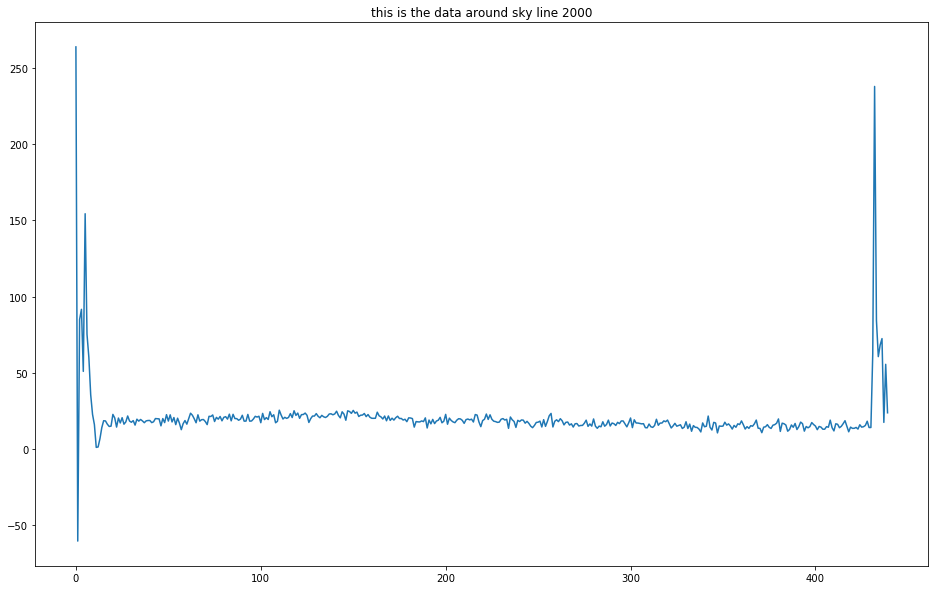

In [14]:
plt.plot(data3)
plt.title('this is the data around sky line 2000')

In [15]:
#model_x = np.linspace(0, len(data2), len(data2)*10)
#plt.plot(model_x)
mymodel=modeling.models.Polynomial1D(7)
#uses these vals from above skyaps=[(30,110),(180,400)] 
subimg, models = comb.subtract_sky(skyaps, skymodel=mymodel)
#maybe=subimg
type(subimg)
#np.shape(subimg)

reduce_dblspec.DoubleSpecImage

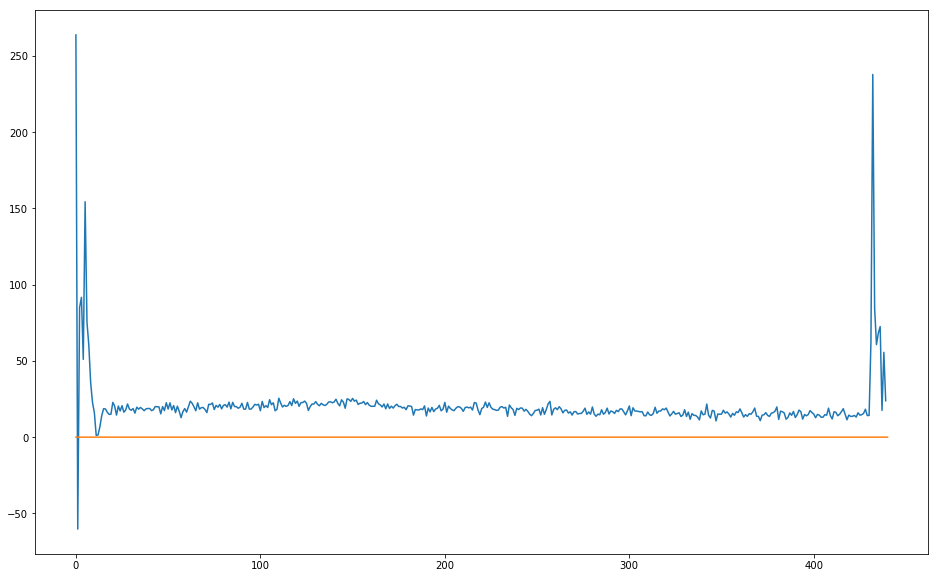

In [16]:
#model=np.array(subimg.data)
#plt.plot(model)
model_data=subimg.data.transpose()
#np.shape(model_data)
model_data2=model_data[2000] #isolating column along a sky emission, model fitted data
fitter = modeling.fitting.LevMarLSQFitter()
plt.plot(data3)
#type(model_data)
model_x = np.linspace(0, len(data3), len(data3)*10) #this has more points so need to go over data not with it
plt.plot(model_x,mymodel(model_x))

In [17]:
#mymodel(test)
np.shape(model_data2)

(440,)

In [18]:
modeling.models.Polynomial1D(7)(test)

array([[ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.]])

model_x (440,)
new_model ()


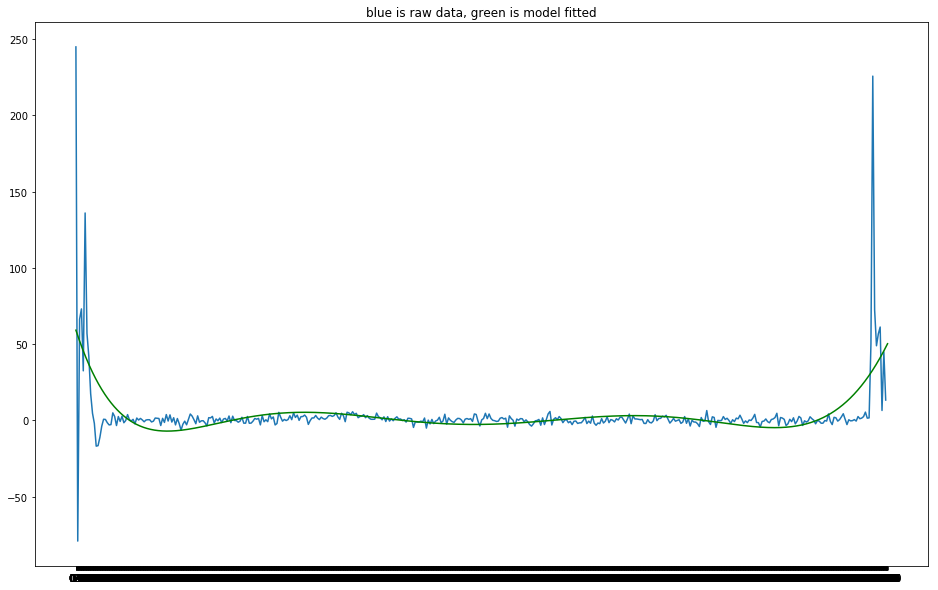

In [70]:
#x = np.arange(10)
x = np.linspace(0, len(model_data2), len(model_data2)*10) #(4400,)
model_x = np.arange(0,len(model_data2))
y = model_data2
#yy = np.array([y, y])
p2 = modeling.models.Polynomial1D(7)#, n_models=1)
#pfit = fitting.LinearLSQFitter()
pfit = modeling.fitting.LevMarLSQFitter()

#for i in yy:
#    print(i)
print('model_x',np.shape(model_x))

#print(np.shape(yy))
new_model = pfit(p2, model_x, y)#, yy)#, yy)
#print(new_model)
print('new_model',np.shape(new_model))
plt.xticks(x)
plt.title('blue is raw data, green is model fitted')
plt.plot(model_x,y)
plt.plot(x,new_model(x),color='g')

In [69]:
x = np.linspace(0, len(model_data2), len(model_data2)*10) #(4400,)
model_x = np.arange(0,len(model_data2))
y = model_data2
p2 = modeling.models.Polynomial1D(3)
pfit = modeling.fitting.LevMarLSQFitter()

#new_model = pfit(p2, x, y)
#print(p2(y)) ## all zeros, this is the problem

#plt.plot(model_x,p2(y))